# **Thư viện**

In [1]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Reshape
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from keras.utils import to_categorical
import matplotlib.gridspec as gridspec
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os

# **Lấy data và random**

1153
[971 414 607 163 580 377  15 577 398 569 264  24]


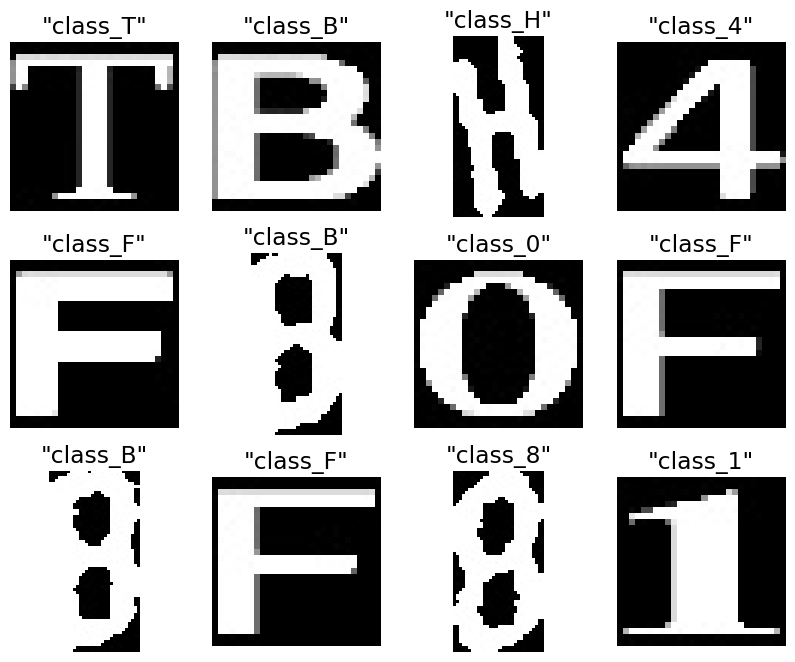

In [2]:
dataset_paths = glob.glob("data/train/**/*.jpg")

cols = 4
rows = 3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols = cols, nrows = rows, figure = fig)

# Tạo một danh sách hình ảnh ngẫu nhiên 
np.random.seed(45)
print(len(dataset_paths))
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))
print(rand)

for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

plt.savefig("Visualize_dataset.jpg",dpi=300)   

# **Sắp xếp dữ liệu đầu vào và nhãn tương ứng**

In [3]:
X = []
labels = []

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("{:d} images with {:d} classes".format(len(X), len(set(labels))))

lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file
np.save('models/license_character_classes.npy', lb.classes_)

1153 images with 36 classes


# **Chia tập train và test**

In [4]:
from sklearn.model_selection import train_test_split

(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)

# **Tăng cường dữ liệu**

In [5]:
image_gen = ImageDataGenerator(
    
                              rotation_range = 10,       # góc quay ngẫu nhiên -10 đến +10 dộ
                              width_shift_range = 0.1,   # dịch ngang -0.1 đến +0.1
                              height_shift_range = 0.1,  # dịch dọc -0.1 đến +0.1
                              shear_range = 0.1,         # biến dạng cắt ảnh -0.1 đến +0.1
                              zoom_range = 0.1,          # phóng to thu nhỏ 0.9 đến 1.1
                              fill_mode = "nearest"

                              )

# **CNN**

In [6]:
def create_model(lr=1e-3, decay=1e-3/25, training=False, output_shape=y.shape[1]):

    model = Sequential()
    # cnn1
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(80, 80, 3)))
    model.add(MaxPooling2D((2, 2)))
    # cnn2 
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    # cnn3
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(output_shape, activation='softmax'))


    if training:
        optimizer = Adam(lr=lr, decay=decay)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


In [7]:
INIT_LR = 1e-3
EPOCHS = 20

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

c:\Users\LeVan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [8]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

BATCH_SIZE = 1

my_checkpointer = [
    
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="models/License_character_recognition.h5", verbose=1, save_weights_only=True)

                ]

result = model.fit(
    
                   image_gen.flow(X_train, y_train, batch_size = BATCH_SIZE), 
                   steps_per_epoch = len(X_train) // BATCH_SIZE, 
                   validation_data = (X_test, y_test), 
                   validation_steps = len(X_test) // BATCH_SIZE, 
                   epochs = EPOCHS, callbacks=my_checkpointer

                   )


Epoch 1/20
1034/1037 [============================>.] - ETA: 0s - loss: 4.9497 - accuracy: 0.3211
Epoch 1: saving model to models\License_character_recognition.h5
1037/1037 [==============================] - 19s 18ms/step - loss: 4.9402 - accuracy: 0.3211 - val_loss: 1.5137 - val_accuracy: 0.6207
Epoch 2/20
1034/1037 [============================>.] - ETA: 0s - loss: 1.5361 - accuracy: 0.5600
Epoch 2: saving model to models\License_character_recognition.h5
1037/1037 [==============================] - 16s 16ms/step - loss: 1.5355 - accuracy: 0.5603 - val_loss: 0.9109 - val_accuracy: 0.7155
Epoch 3/20
1036/1037 [============================>.] - ETA: 0s - loss: 1.1110 - accuracy: 0.6593
Epoch 3: saving model to models\License_character_recognition.h5
1037/1037 [==============================] - 18s 18ms/step - loss: 1.1101 - accuracy: 0.6596 - val_loss: 0.5114 - val_accuracy: 0.8017
Epoch 4/20
1036/1037 [============================>.] - ETA: 0s - loss: 0.9516 - accuracy: 0.6988
Epoch 4:

In [9]:
import tensorflow.keras.backend as K

test_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'data'

test_generator = test_datagen.flow_from_directory(
        path+'/val', 
        target_size=(80,80),  
        class_mode='sparse')

Found 300 images belonging to 36 classes.


# **Đồ thị**

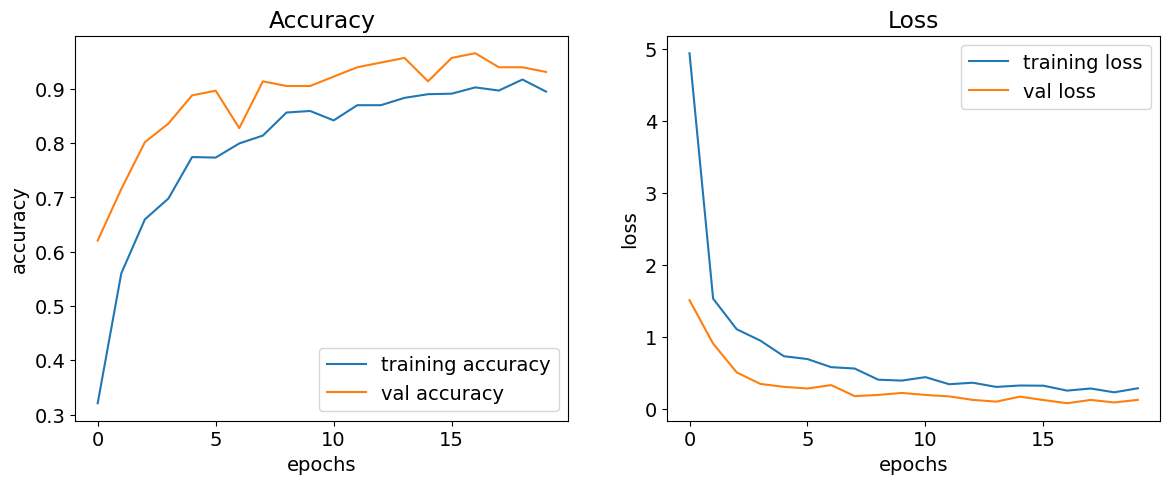

In [10]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# **Lưu model file .json**

In [11]:
# save model file json
model_json = model.to_json()
with open("models/Model.json", "w") as json_file:
  json_file.write(model_json)

In [12]:
import cv2
plate_cascade = cv2.CascadeClassifier('data/indian_license_plate.xml')

# **Nhận dạng và khoanh vùng chứa biển số xe** 

(363, 272, 3)


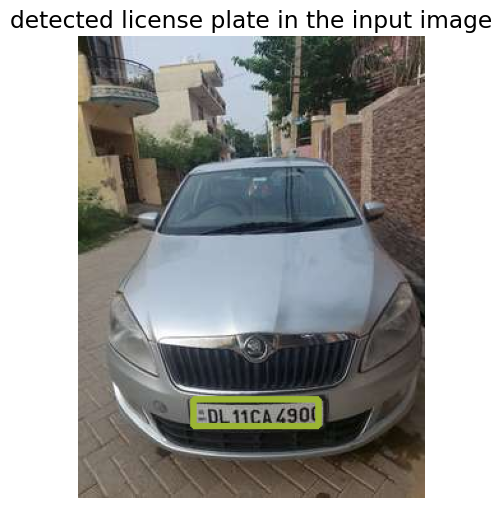

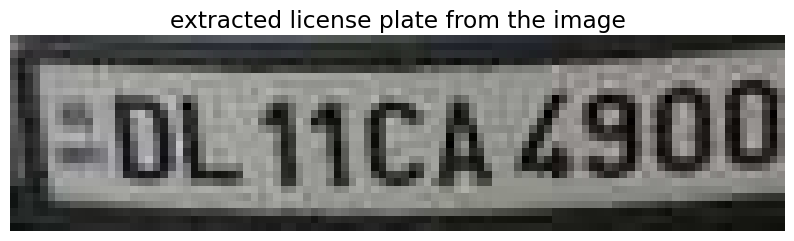

In [13]:
def detect_plate(img, text=''):
    plate_img = img.copy()
    roi = img.copy()
    plates = plate_cascade.detectMultiScale(plate_img, scaleFactor=1.2, minNeighbors=7)

    for (x, y, w, h) in plates:
        roi_ = roi[y:y+h, x:x+w, :]
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2, y), (x+w-3, y+h-5), (51, 181, 155), 3)  # Vẽ hcn bao quanh biển số

        # Hiển thị chữ lên ảnh
        if text != '':
            plate_img = cv2.putText(plate_img, text, (x-w//2, y-h//2),
                                    cv2.FONT_HERSHEY_COMPLEX_SMALL, 1,
                                    (0, 255, 155), 2, cv2.LINE_AA)

    return plate_img, plate
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()
img = cv2.imread('data/DL14.jpg')
output_img, plate = detect_plate(img)
print(output_img.shape)
display(output_img, 'detected license plate in the input image')
display(plate, 'extracted license plate from the image')

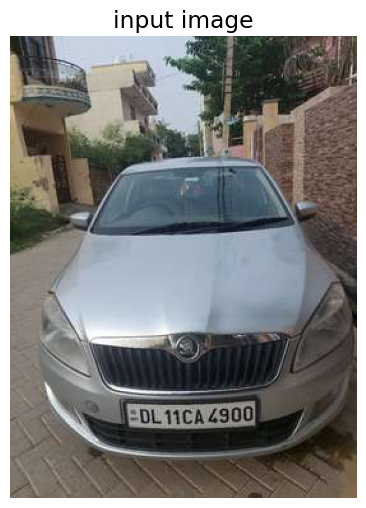

In [17]:
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread('data/DL14.jpg')
display(img, 'input image')

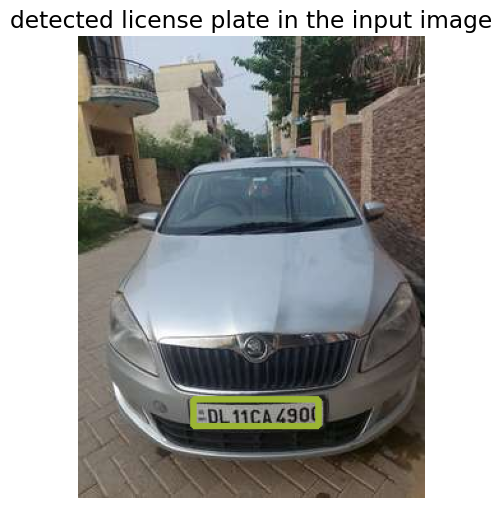

In [18]:
output_img, plate = detect_plate(img)
display(output_img, 'detected license plate in the input image')

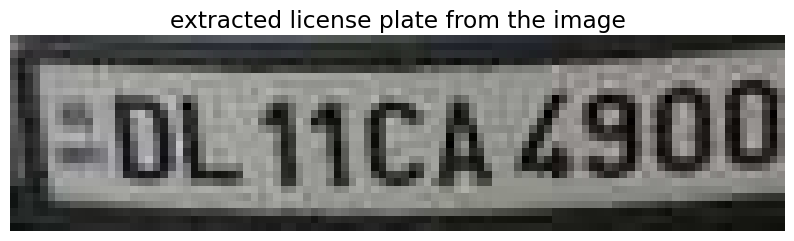

In [29]:
display(plate, 'extracted license plate from the image')

# **Tìm và trích xuất các đường viền**

In [33]:
def find_contours(dimensions, img) :

    # Tìm tất cả các đường viền trong ảnh
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Truy xuất kích thước tiềm năng
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Sắp xếp các đường viền 
    cntrs = sorted(cntrs, key = cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # phát hiện đường viền trong ảnh nhị phân và trả về tọa độ của hình chữ nhật bao quanh nó
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # kiểm tra kích thước của đường viền để lọc ra các ký tự theo kích thước của đường viền
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) # Lưu tọa độ x của đường viền ký tự

            char_copy = np.zeros((44,24))
            # trích xuất từng ký tự bằng tọa độ của hình chữ nhật
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50, 21, 200), 2)
            plt.imshow(ii, cmap='gray')

            # Đảo ngược color
            char = cv2.subtract(255, char)

            # Thay đổi kích thước hình ảnh thành 24x44 với viền đen
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # Danh sách lưu trữ hình ảnh nhị phân của ký tự (chưa sắp xếp)
            
    plt.show()
    # Lưu trữ danh sách các chỉ số ký tự được sắp xếp
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx]) # lưu hình ảnh theo index 
    img_res = np.array(img_res_copy)

    return img_res

# **Chia nhỏ hình ảnh biển số xe để tìm và trích xuất các ký tự**

In [34]:
# Tìm ký tự trong hình ảnh kết quả
def segment_characters(image) :

    # Hình ảnh biển số xe đã cắt tiền xử lý
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Tạo đường viền màu trắng
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Ước tính kích thước đường viền ký tự của biển số xe đã cắt
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

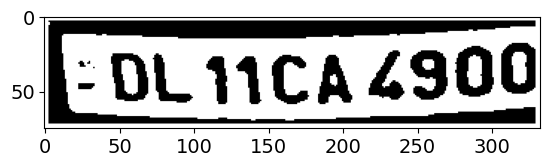

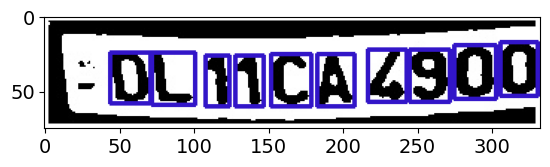

In [35]:
char = segment_characters(plate)

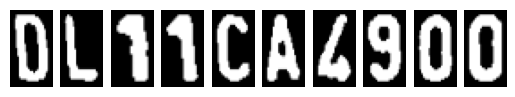

In [36]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

# **Tải mô hình**

In [37]:
from keras.models import model_from_json

json_file = open('models/Model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

model = model_from_json(loaded_model_json)
model.load_weights("models/License_character_recognition.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('models/license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 78, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 128)        0

# **Hiển thị kết quả dự đoán**

In [40]:
# Dự đoán đầu ra
def fix_dimension(img): 
  new_img = np.zeros((80,80,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results(char):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for ch in char:  # Lặp qua các ký tự 
        img_ = cv2.resize(ch, (80, 80), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1, 80, 80, 3)
        y_ = model.predict(img)[0] # dự đoán đầu ra 
        character = dic[np.argmax(y_)] # Tìm số lớp nhất trong y_ 
        output.append(character)  

    plate_number = ''.join(output)

    return plate_number


1/1 [==============================] - 0s 29ms/step
DL11CA490O


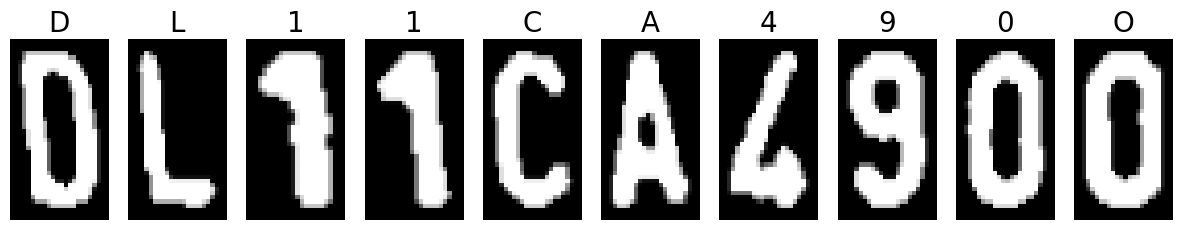

In [41]:
fig = plt.figure(figsize=(15, 3))
cols = len(char)
grid = gridspec.GridSpec(ncols=cols, nrows=1, figure=fig)

final_string = ''
for i, character in enumerate(char):
    fig.add_subplot(grid[i])
    plt.imshow(character, cmap='gray')
    plt.title(f'{show_results([character])}', fontsize=20)
    final_string += show_results([character])
    plt.axis(False)

print(final_string)
plt.show()

In [42]:
img = cv2.imread('data/DL14.jpg')

In [43]:
plate_number = show_results(char)
output_img, plate = detect_plate(img, plate_number)
print(plate_number)

1/1 [==============================] - 0s 34ms/step
DL11CA490O


# **Hiển thị kết quả lên ảnh**

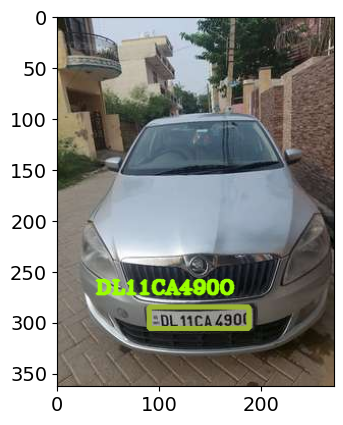

In [44]:
output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
plt.imshow(output_img_rgb)